In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Environmental/Plant_1_Weather_Sensor_Data.csv')
df.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [5]:
df.tail()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
3177,2020-06-17 22:45:00,4135001,HmiyD2TTLFNqkNe,22.150570,21.480377,0.0
3178,2020-06-17 23:00:00,4135001,HmiyD2TTLFNqkNe,22.129816,21.389024,0.0
3179,2020-06-17 23:15:00,4135001,HmiyD2TTLFNqkNe,22.008275,20.709211,0.0
3180,2020-06-17 23:30:00,4135001,HmiyD2TTLFNqkNe,21.969495,20.734963,0.0
3181,2020-06-17 23:45:00,4135001,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0


In [6]:
df.shape

(3182, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   MODULE_TEMPERATURE   3182 non-null   float64
 5   IRRADIATION          3182 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 149.3+ KB


In [7]:
time = pd.date_range(start='5/15/2020',periods=3182,freq='15min')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['DATE_TIME','PLANT_ID','SOURCE_KEY'],axis=1,inplace=True)
df = df.set_index('time_stamp')
df = df[['AMBIENT_TEMPERATURE']]

In [8]:
df.head()

,AMBIENT_TEMPERATURE
time_stamp,
2020-05-15 00:00:00,25.184316
2020-05-15 00:15:00,25.084589
2020-05-15 00:30:00,24.935753
2020-05-15 00:45:00,24.846130
2020-05-15 01:00:00,24.621525


In [9]:
plt.rcParams['figure.figsize'] = [15,8]

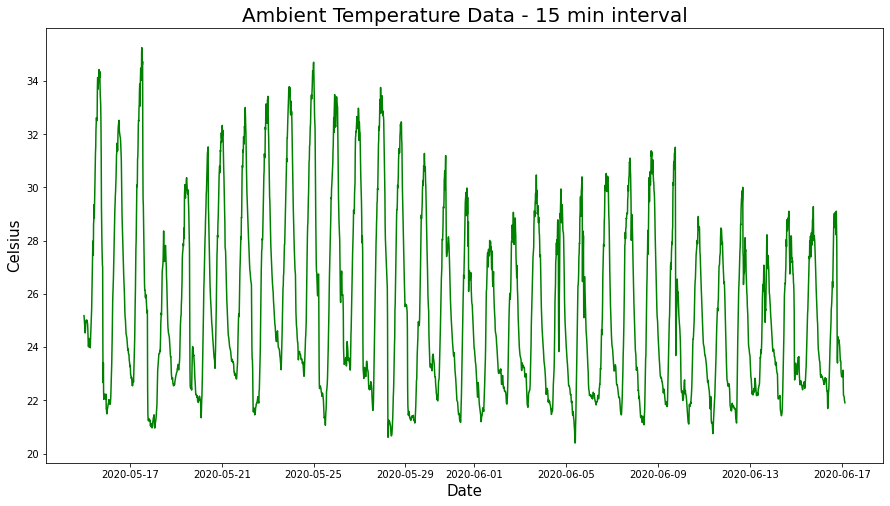

In [10]:
plt.plot(df,color='green')
plt.title('Ambient Temperature Data - 15 min interval',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Celsius',fontsize=15)
plt.show()

In [11]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [49]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['AMBIENT_TEMPERATURE'] = df['AMBIENT_TEMPERATURE'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [50]:
#Split data set into testing dataset and train dataset
train_size = 2800
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 4
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(2796, 1, 4)
(2796,)
(378, 1, 4)
(378,)


In [15]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 5.0 MB/s 


In [16]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [17]:
def build_model(hp):
    model = keras.Sequential()
    model.add(LSTM(hp.Int('rnn_layer',min_value=4,max_value=96,step=4), activation="relu",input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.1,0.2,0.3],default=0.2)))
    model.add(Dense(hp.Int('dense_layer',min_value=4,max_value=96,step=4),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [18]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_1')

In [19]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
rnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 96, 'step': 4, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.1, 0.2, 0.3], 'ordered': True}
dense_layer (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 96, 'step': 4, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [20]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=37,
             validation_data=(testX, testY))

Trial 10 Complete [00h 00m 50s]
val_mape: 3.878230094909668

Best val_mape So Far: 2.859934091567993
Total elapsed time: 00h 11m 49s
INFO:tensorflow:Oracle triggered exit


In [21]:
tuner.results_summary()

Results summary
Results in project/loa_em_1
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
rnn_layer: 52
first_recurrent_dropout: 0.3
dense_layer: 28
Dropout_rate: 0.0
learning_rate: 0.005096279648146842
Score: 2.859934091567993
Trial summary
Hyperparameters:
rnn_layer: 16
first_recurrent_dropout: 0.1
dense_layer: 56
Dropout_rate: 0.2
learning_rate: 0.005397157428417426
Score: 2.916430711746216
Trial summary
Hyperparameters:
rnn_layer: 32
first_recurrent_dropout: 0.3
dense_layer: 92
Dropout_rate: 0.1
learning_rate: 0.0008556581060099099
Score: 2.920215129852295
Trial summary
Hyperparameters:
rnn_layer: 92
first_recurrent_dropout: 0.1
dense_layer: 40
Dropout_rate: 0.2
learning_rate: 0.006955293637526899
Score: 2.944145441055298
Trial summary
Hyperparameters:
rnn_layer: 80
first_recurrent_dropout: 0.2
dense_layer: 64
Dropout_rate: 0.2
learning_rate: 0.013781243842433944
Score: 3.029107093811035
Trial summary
Hyperparameters:
rnn_layer: 3

In [22]:
from warnings import filterwarnings
filterwarnings('ignore')

In [24]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 4))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 52)                11856     
                                                                 
 dense (Dense)               (None, 28)                1484      
                                                                 
 dropout (Dropout)           (None, 28)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 29        
                                                                 
Total params: 13,369
Trainable params: 13,369
Non-trainable params: 0
_________________________________________________________________


In [26]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [54]:
model = Sequential()
model.add(LSTM(128,activation='relu',input_dim = 4,return_sequences=True,recurrent_dropout=0.2))
model.add(LSTM(64,activation='relu',recurrent_dropout=0.1))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate = 0.00005096279648146842)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 37, epochs = 400,callbacks=[EarlyStopping(monitor='val_loss', patience=60)])

Epoch 1/400
76/76 [==============================] - 6s 13ms/step - loss: 97.9346 - mape: 97.9346 - val_loss: 95.9043 - val_mape: 95.9043
Epoch 2/400
76/76 [==============================] - 0s 6ms/step - loss: 93.8442 - mape: 93.8442 - val_loss: 91.3018 - val_mape: 91.3018
Epoch 3/400
76/76 [==============================] - 0s 6ms/step - loss: 88.8953 - mape: 88.8953 - val_loss: 85.7213 - val_mape: 85.7213
Epoch 4/400
76/76 [==============================] - 0s 6ms/step - loss: 82.6836 - mape: 82.6836 - val_loss: 78.5780 - val_mape: 78.5780
Epoch 5/400
76/76 [==============================] - 0s 6ms/step - loss: 74.6112 - mape: 74.6112 - val_loss: 69.2733 - val_mape: 69.2733
Epoch 6/400
76/76 [==============================] - 0s 6ms/step - loss: 64.0043 - mape: 64.0043 - val_loss: 57.0313 - val_mape: 57.0313
Epoch 7/400
76/76 [==============================] - 0s 6ms/step - loss: 49.8290 - mape: 49.8290 - val_loss: 40.5690 - val_mape: 40.5690
Epoch 8/400
76/76 [=====================

In [55]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [56]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 3.21 
Test MAPE : 3.44 


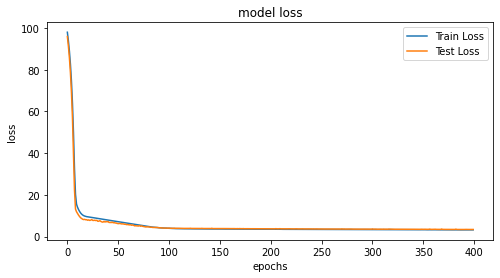

In [57]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [38]:
import seaborn as sns

In [58]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(2796,3174)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

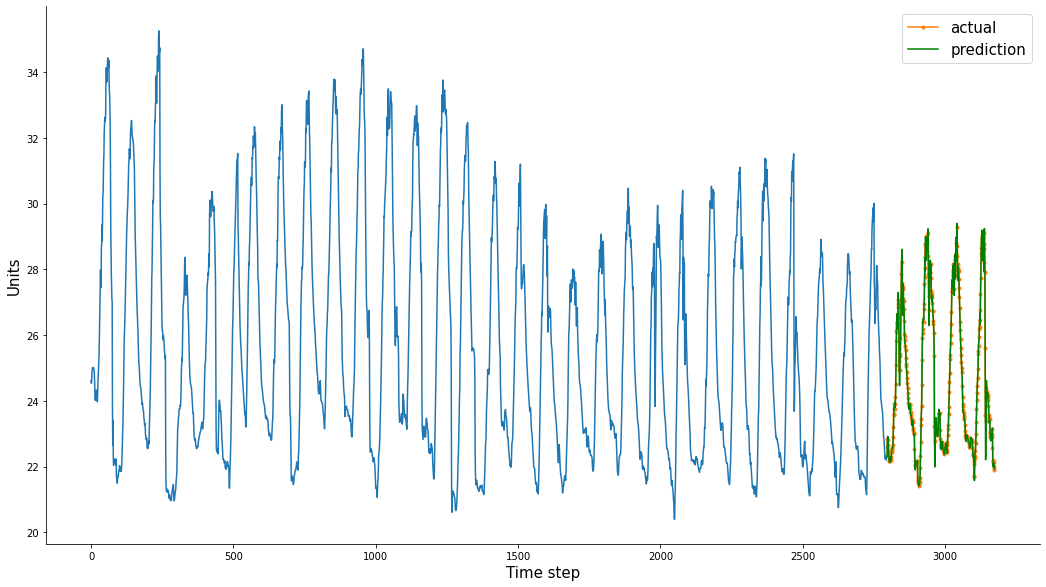

In [59]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)